In this notebook I will verify various parts of the input for the workflow.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr20"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")

Filter_Excesshet is not present, so I check ExcessHet. It gives phred-scaled p-values, so I choose a fitting number to investigate this.

In [10]:
Excesshet = callset["variants/ExcessHet"][:]

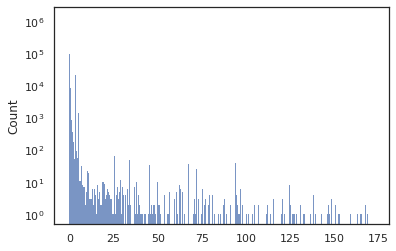

In [22]:
g = sns.histplot(Excesshet)
#g.set_xscale("log")
g.set_yscale("log")

In [20]:
sum(Excesshet > 20)

20683

In [17]:
len(Excesshet)

3577729

Checking the various variant fields

In [23]:
callset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…